## Bayesian Diabetes Modeling

This notebook contains models for predicting diabetes. 

Explore Bayesian approach, eg such as this one for financial data:

http://docs.pymc.io/notebooks/GLM-logistic.html



We'll work with this dataset:

https://archive.ics.uci.edu/ml/datasets/Diabetes

Here's a link to processed UCI data:

http://www.bioinf.jku.at/people/klambauer/data_py.zip

### first use _these_ data

I'm going to download  simple csv from kaggle --this is a subset

https://www.kaggle.com/uciml/pima-indians-diabetes-database/data

Reference: Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2245318/



### other slightly related data for later

More diabetes data for further investigation:

https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

https://catalog.data.gov/dataset?tags=diabetes

```
from sklearn import datasets
diabetes = datasets.load_diabetes()
diabetes
```

## Load python machine learning stack

In [1]:
import sys, os
import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter

In [2]:
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [3]:
import matplotlib
matplotlib.style.use('ggplot')
import itertools

In [4]:
from __future__ import print_function

import keras


from keras.utils.np_utils import to_categorical

Using TensorFlow backend.
/opt/mkm_virts/mc36/envs/cdp36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [6]:
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [7]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
from sklearn.model_selection import cross_val_score

from sklearn.grid_search import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns

from IPython.core.pylabtools import figsize

from scipy.stats import percentileofscore
from scipy import stats

In [9]:
# Distributions
import scipy

In [10]:
# Use PyMC3 for Bayesian Inference
import pymc3 as pm

## Load data

Attributes
-------

**Pregnancies**: Number of times pregnant

**Glucose**: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

**BloodPressure**: Diastolic blood pressure (mm Hg)

**SkinThickness**: Triceps skin fold thickness (mm)

**Insulin**: 2-Hour serum insulin (mu U/ml)

**BMI**: Body mass index (weight in kg/(height in m)^2)

**DiabetesPedigreeFunction**: Diabetes pedigree function

**Age**: Age (years)

**Outcome**: Class variable (0=non diabetic or 1=diabetic)


We'll need to load the data and manipulate it a bit.

In [11]:
df = pd.read_csv('pima_diabetes_subset.csv')
len(df)

768

In [12]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [13]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Imputation

While we are not missing values some have been filled with nonsense, these can't be zero:
- SkinThickness
- Insulin
- BMI
- Glucose
- Blood pressure

we'll replace zero values with the median.

In [15]:
median_skinthickness = df['SkinThickness'].median()
median_insulin = df['Insulin'].median()
median_bmi = df['BMI'].median()
median_glucose = df['Glucose'].median()
median_skinthickness, median_insulin, median_bmi, median_glucose

(23.0, 30.5, 32.0, 117.0)

In [16]:
median_blood_pressure = df['BloodPressure'].median()
median_blood_pressure

72.0

In [17]:
df['SkinThickness'] = df['SkinThickness'].apply(lambda x: median_skinthickness if x == 0 else x)
df['SkinThickness'].describe()

count    768.000000
mean     27.334635 
std      9.229014  
min      7.000000  
25%      23.000000 
50%      23.000000 
75%      32.000000 
max      99.000000 
Name: SkinThickness, dtype: float64

In [18]:
df['Insulin'] = df['Insulin'].apply(lambda x: median_insulin if x == 0 else x)
df['Insulin'].describe()

count    768.000000
mean     94.652344 
std      105.547598
min      14.000000 
25%      30.500000 
50%      31.250000 
75%      127.250000
max      846.000000
Name: Insulin, dtype: float64

In [19]:
df['BMI'] = df['BMI'].apply(lambda x: median_bmi if x == 0 else x)
df['BMI'].describe()

count    768.000000
mean     32.450911 
std      6.875366  
min      18.200000 
25%      27.500000 
50%      32.000000 
75%      36.600000 
max      67.100000 
Name: BMI, dtype: float64

In [20]:
df['Glucose'] = df['Glucose'].apply(lambda x: median_glucose if x == 0 else x)
df['Glucose'].describe()

count    768.000000
mean     121.656250
std      30.438286 
min      44.000000 
25%      99.750000 
50%      117.000000
75%      140.250000
max      199.000000
Name: Glucose, dtype: float64

In [21]:
df['BloodPressure'] = df['BloodPressure'].apply(lambda x: median_blood_pressure if x == 0 else x)
df['BloodPressure'].describe()

count    768.000000
mean     72.386719 
std      12.096642 
min      24.000000 
25%      64.000000 
50%      72.000000 
75%      80.000000 
max      122.000000
Name: BloodPressure, dtype: float64

## Visualization

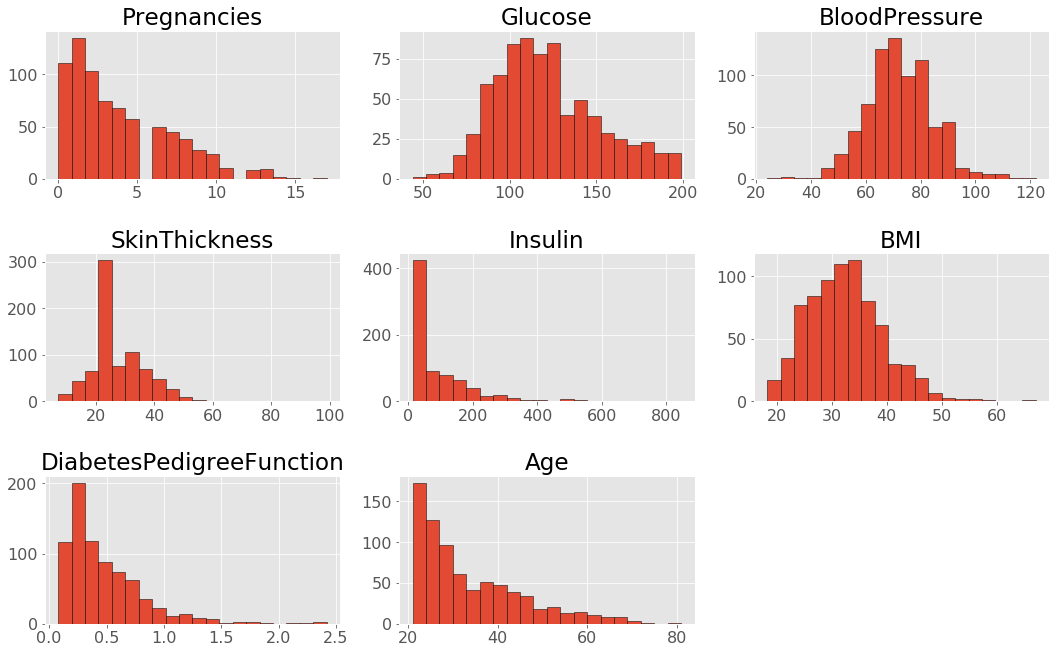

In [22]:
columns=df.columns[:8]
plt.subplots(figsize=(18,15))
length=len(columns)
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot((length/2),3,j+1)
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    df[i].hist(bins=20,edgecolor='black')
    plt.title(i)
plt.show()

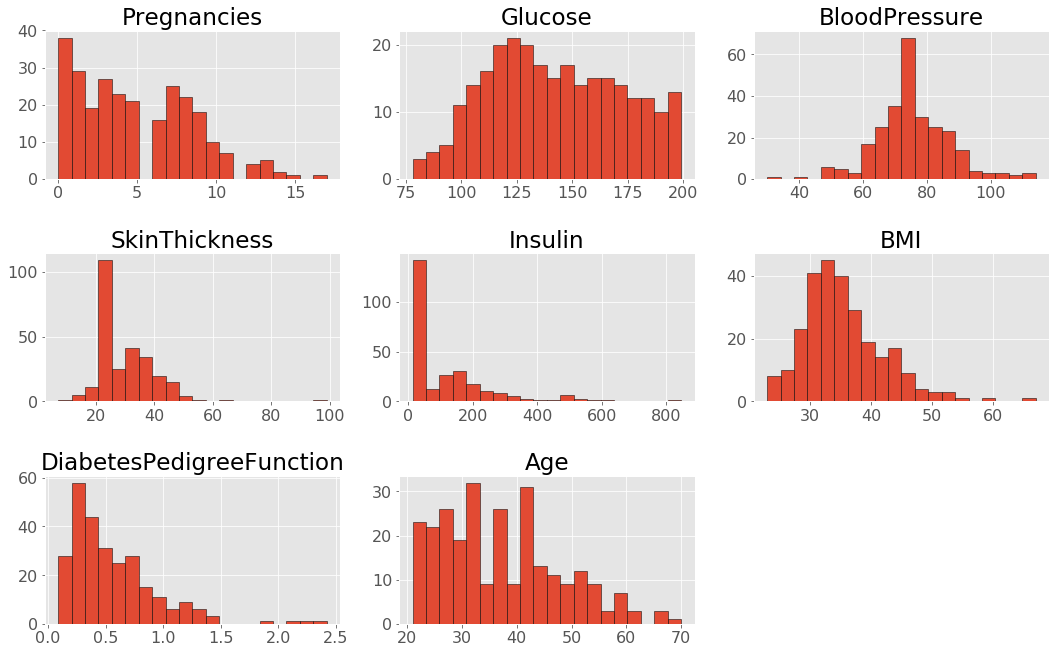

In [23]:
# Diabetes only
diab1=df[df['Outcome']==1]
columns=diab1.columns[:8]
plt.subplots(figsize=(18,15))
length=len(columns)
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot((length/2),3,j+1)
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    diab1[i].hist(bins=20,edgecolor='black')
    plt.title(i)
plt.show()

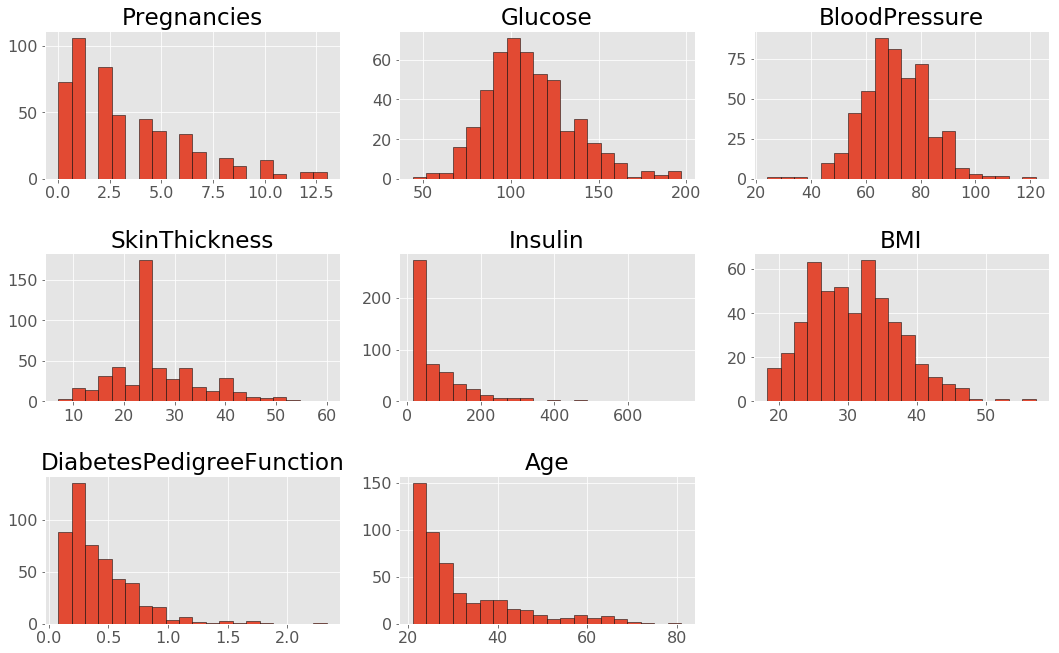

In [24]:
# Non diabetes
diab0=df[df['Outcome']==0]
columns=diab0.columns[:8]
plt.subplots(figsize=(18,15))
length=len(columns)
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot((length/2),3,j+1)
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    diab0[i].hist(bins=20,edgecolor='black')
    plt.title(i)
plt.show()

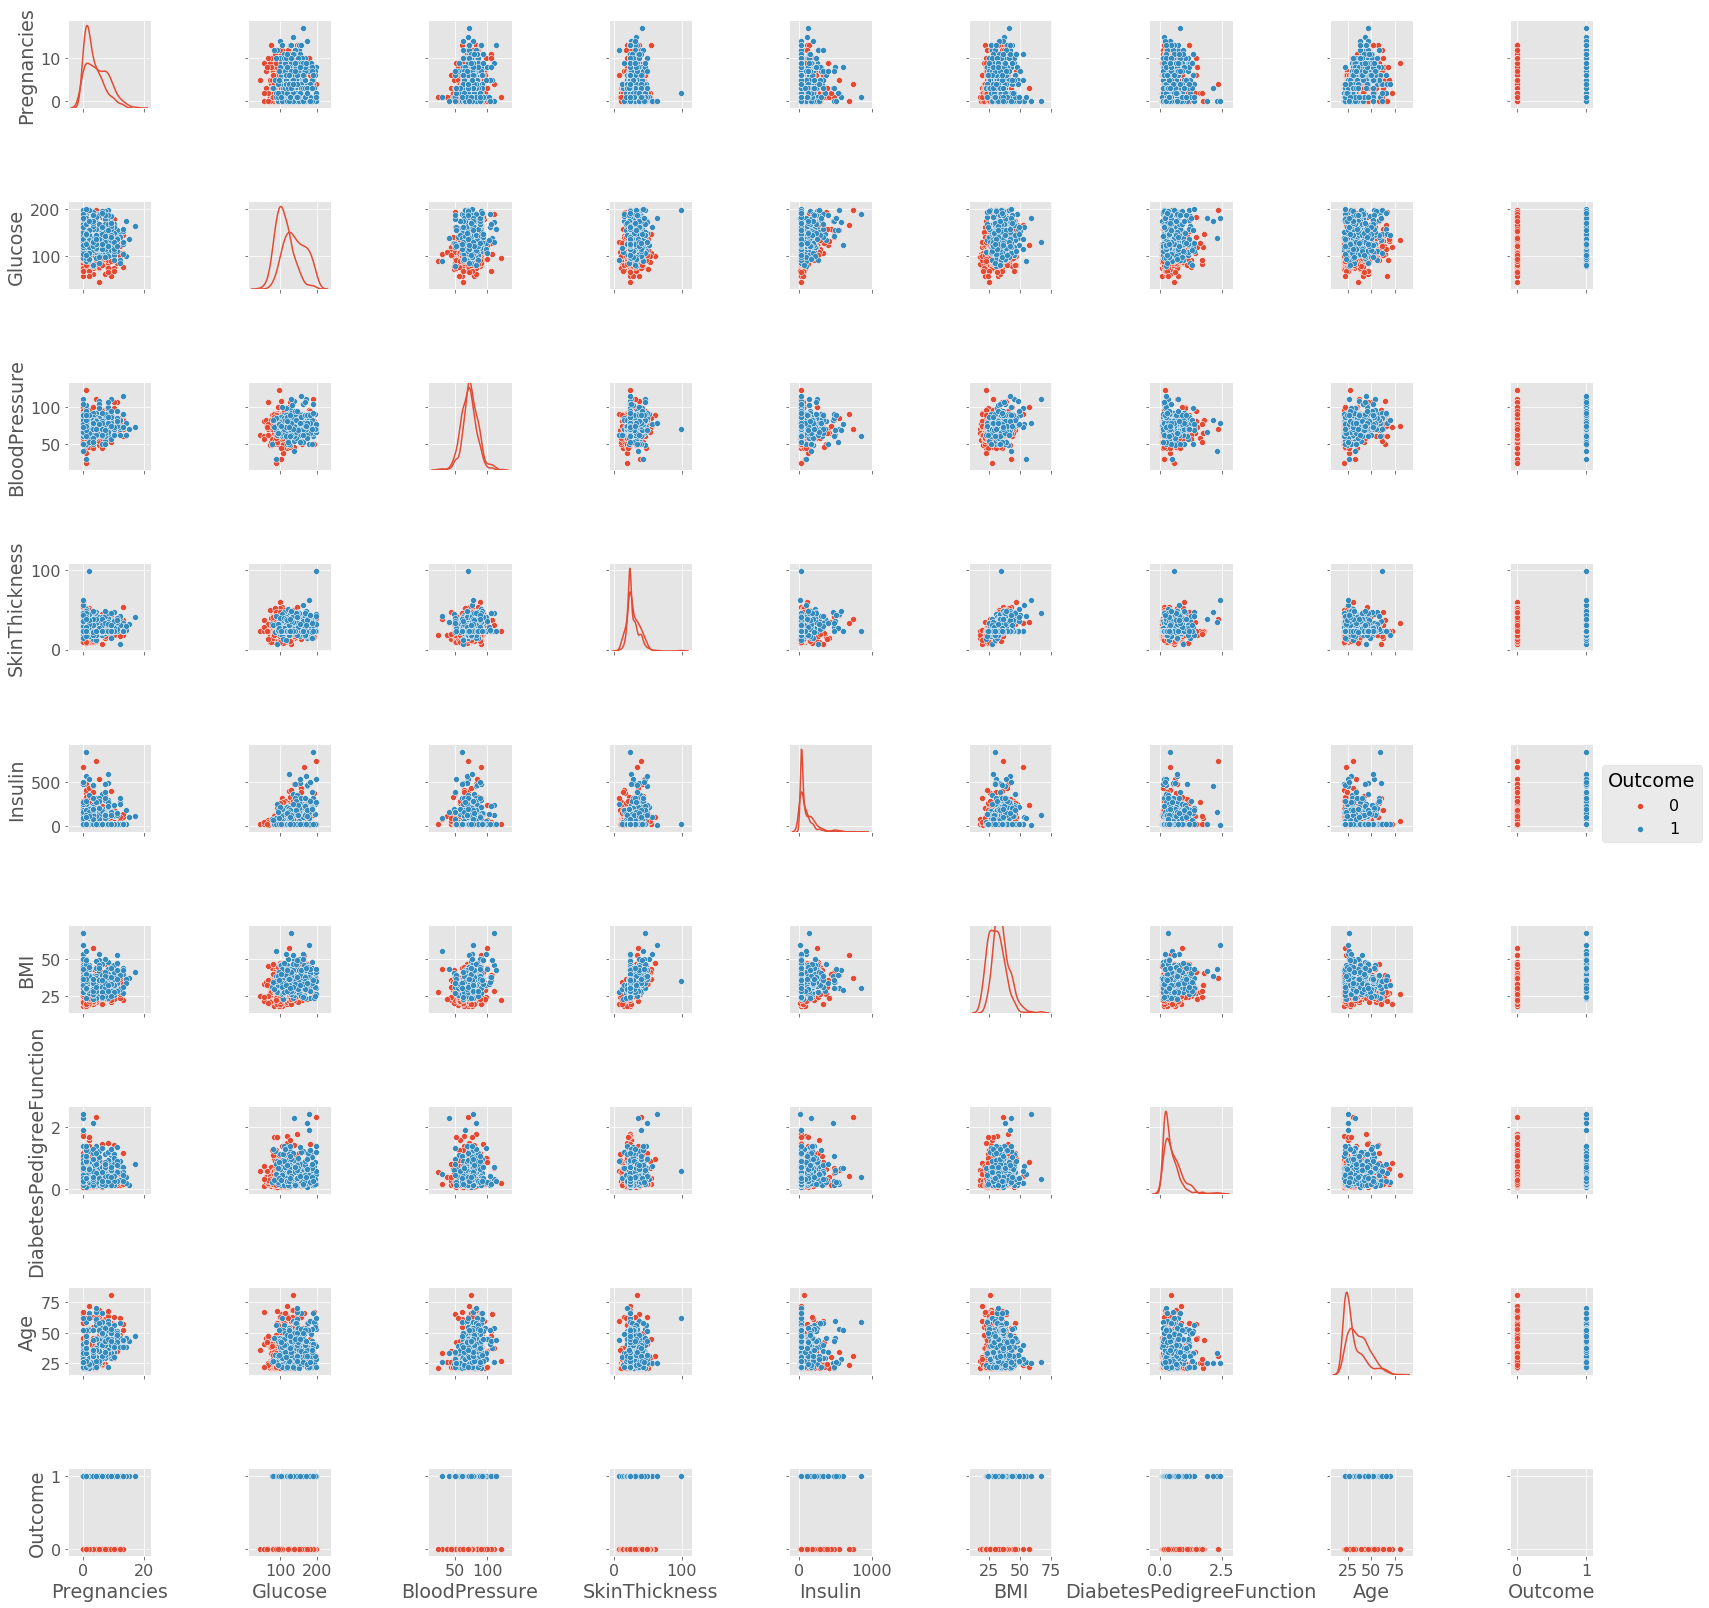

In [25]:
# these are good for looking for non-linear relationships
sns.pairplot(data=df,hue='Outcome',diag_kind='kde')
plt.show()

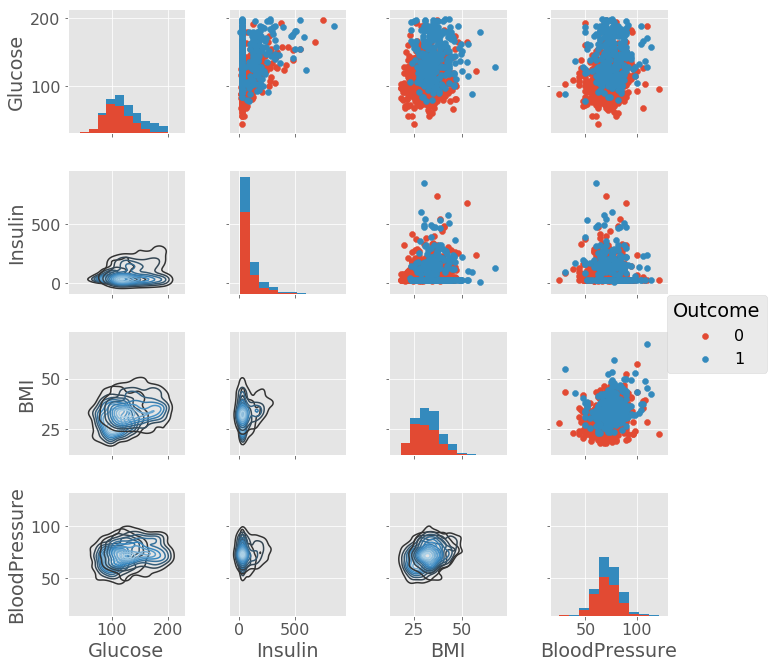

In [26]:
g = sns.PairGrid(df, vars=['Glucose', 'Insulin', 'BMI', 'BloodPressure'], hue="Outcome", size=2.4)
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.add_legend()
plt.show()

### Check class balance of dataset

In [27]:
df['Outcome'].sum()

268

#### If we predict only 0 on all data (majority class) we'll get the following accuracy

In [28]:
1 - df['Outcome'].sum() / len(df)

0.6510416666666667

In [29]:
df.columns, len(df.columns)

(Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
        'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
       dtype='object'), 9)

In [30]:
cols = df.columns
train_cols = cols[0:8]
test_col = cols[8]

In [31]:
def report_loss_scores(y_true_cat, y_pred_probs):
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_true_cat, axis=1)
    print('the loss: ', log_loss(y_true_cat, y_pred_probs))
    print('accuracy: ', accuracy_score(y_true, y_pred))
    print('recall:   ', recall_score(y_true, y_pred, average='macro'))
    print('precision:', precision_score(y_true, y_pred, average='macro'))
    print('f1 score: ', f1_score(y_true, y_pred, average='macro'))
    print('confusion matrix:\n', confusion_matrix(y_true, y_pred))
    return

## Bayesian classification

We calculate the posterior P(W|X) ie the probability of our weights given our data (X) as:

$$ P(W|X) = \frac{P(X|W)(P(W)}{P(X)}$$

Since the marginal is a difficult integral

$$ P(X) = \int P(X|W) P(W) dW $$ 

we don't do calculated it but sample our posterior given a prior and the a binomial likelihood over our parameter space.  The hope is that if we draw more samples our approximate posterior will converge to the proper posterior.

When this is done we have an idea of

$$ y \sim \mathcal{N}(\frac{1}{1+e^{-z}}, \sigma^2) $$

and 

$$ z = W^T X + b $$


In [32]:
labels = df['Outcome']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, 
                                                    test_size = 0.2,
                                                    random_state=42)

In [34]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
60,2,84.0,72.0,23.0,30.5,32.0,0.304,21,0
618,9,112.0,82.0,24.0,30.5,28.2,1.282,50,1
346,1,139.0,46.0,19.0,83.0,28.7,0.654,22,0
294,0,161.0,50.0,23.0,30.5,21.9,0.254,65,0
231,6,134.0,80.0,37.0,370.0,46.2,0.238,46,1


In [35]:
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.742671,121.807818,72.229642,26.991857,95.843648,32.348208,0.469168,32.907166,0.346906
std,3.313264,30.105181,12.099278,8.782951,106.736205,6.935618,0.336847,11.503437,0.476373
min,0.000000,44.000000,24.000000,8.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,100.000000,64.000000,23.000000,30.500000,27.325000,0.241500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,42.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,139.000000,80.000000,32.000000,129.750000,36.375000,0.613750,40.000000,1.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [36]:
#scaler = StandardScaler()
scaler = MinMaxScaler()

In [37]:
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=df.columns)
X_test =  pd.DataFrame(scaler.transform(X_test), columns=df.columns)

In [38]:
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.220157,0.501986,0.492139,0.345306,0.098370,0.289329,0.167023,0.198453,0.346906
std,0.194898,0.194227,0.123462,0.159690,0.128289,0.141833,0.143829,0.191724,0.476373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.361290,0.408163,0.272727,0.019832,0.186605,0.069812,0.050000,0.000000
50%,0.176471,0.470968,0.489796,0.272727,0.034255,0.282209,0.125747,0.133333,0.000000
75%,0.352941,0.612903,0.571429,0.436364,0.139123,0.371677,0.228757,0.316667,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
X_train.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

### calculate logistic regression preformance for comparision later

In [40]:
lr = LogisticRegression()
lr.fit(X_train[train_cols], y_train)

ols_formula = 'Grade = %0.2f +' % lr.intercept_
for i, col in enumerate(train_cols):
    ols_formula += ' %0.2f * %s +' % (lr.coef_[0][i], col)
    
' '.join(ols_formula.split(' ')[:-1])

'Grade = -3.80 + 0.85 * Pregnancies + 3.84 * Glucose + -0.73 * BloodPressure + 0.39 * SkinThickness + -0.44 * Insulin + 2.69 * BMI + 0.86 * DiabetesPedigreeFunction + 1.54 * Age'

In [41]:
y_probs = lr.predict_proba(X_test[train_cols].values)
report_loss_scores(to_categorical(y_test.values), y_probs)

the loss:  0.5008815354
accuracy:  0.772727272727
recall:    0.734343434343
precision: 0.756843800322
f1 score:  0.742191610465
confusion matrix:
 [[86 13]
 [22 33]]


### Build Bayesian model




In [42]:
formula = 'Outcome ~ ' + ' + '.join(train_cols)
formula

'Outcome ~ Pregnancies + Glucose + BloodPressure + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age'

In [43]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula, X_train, family=pm.glm.families.Binomial())
    trace_logistic_model = pm.sample(2000, chains=1, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Age, DiabetesPedigreeFunction, BMI, Insulin, SkinThickness, BloodPressure, Glucose, Pregnancies, Intercept]
100%|██████████| 3000/3000 [00:30<00:00, 98.99it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [44]:
# Show the trace with a vertical line at the mean of the trace
def plot_trace(trace):
    # Traceplot with vertical lines at the mean value
    ax = pm.traceplot(trace, figsize=(14, len(trace.varnames)*1.8),
                      lines={k: v['mean'] for k, v in pm.df_summary(trace).iterrows()})
    
    matplotlib.rcParams['font.size'] = 16
    
    # Labels with the median value
    for i, mn in enumerate(pm.df_summary(trace)['mean']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data', size = 8,
                          xytext = (-18, 18), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', fontsize = 'large', color = 'red')

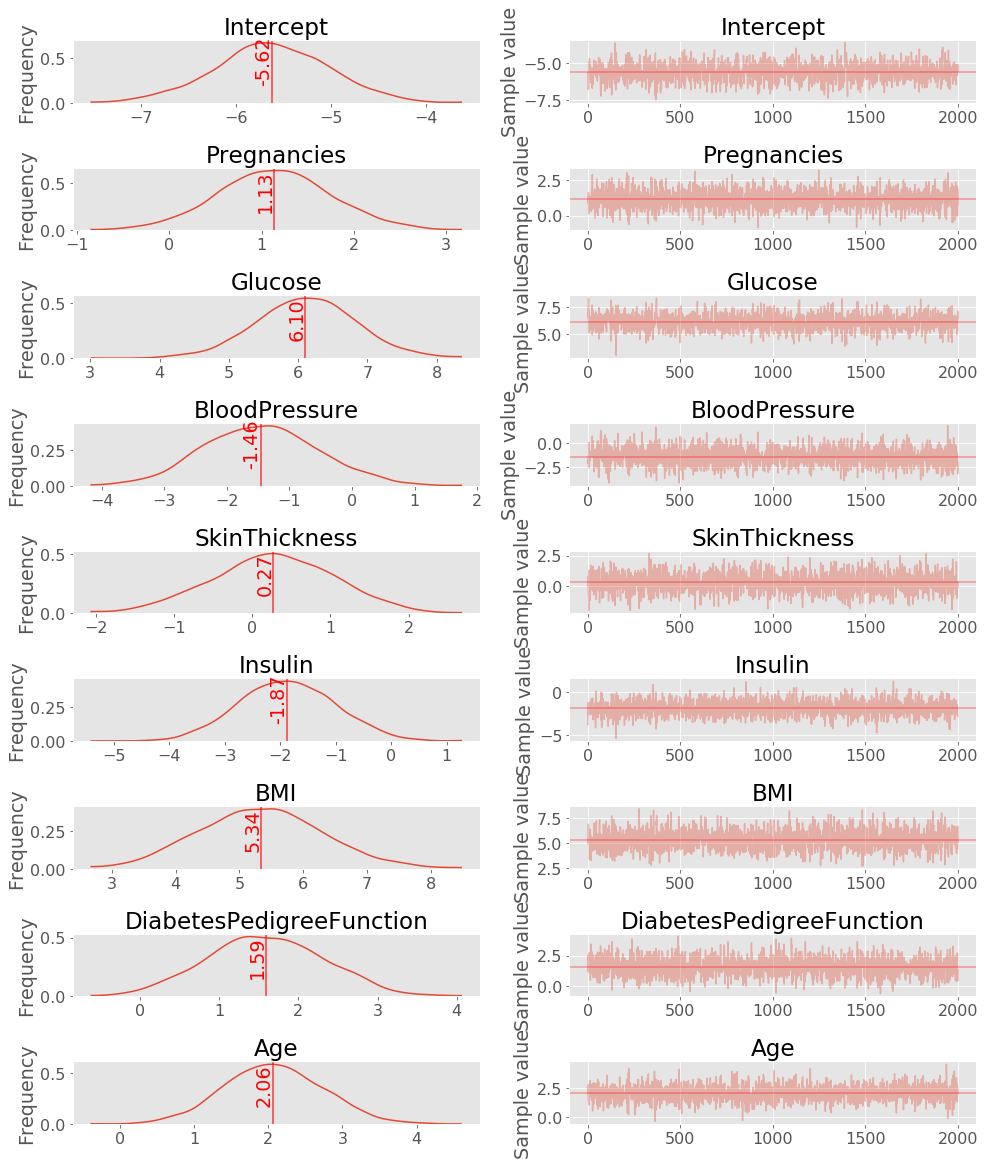

In [45]:
plot_trace(trace_logistic_model)

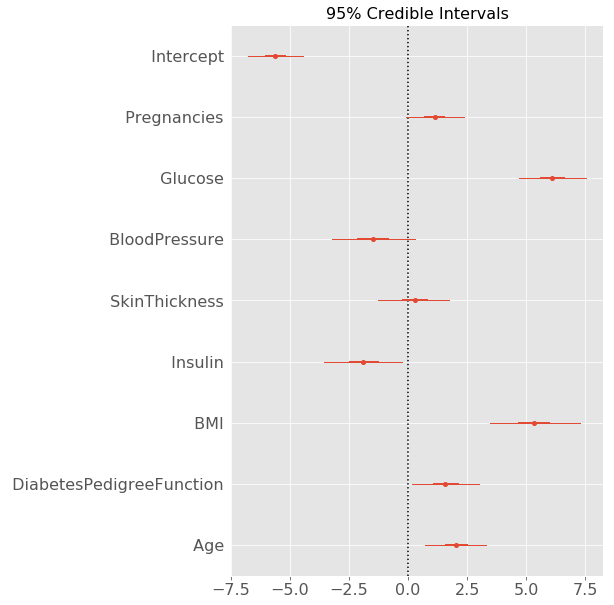

In [46]:
pm.forestplot(trace_logistic_model)

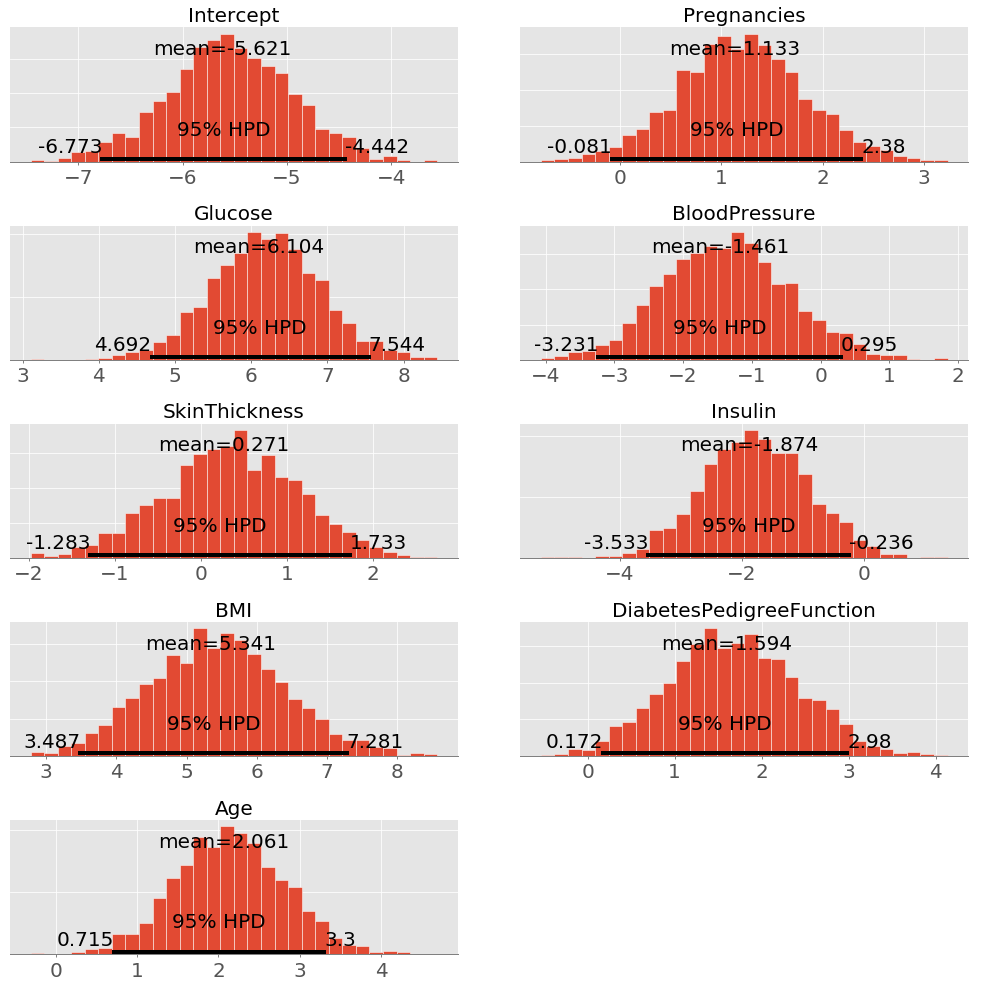

In [47]:
pm.plot_posterior(trace_logistic_model, figsize = (14, 14), text_size=20);

In [48]:
for variable in trace_logistic_model.varnames:
    print('Variable: {:35} Mean weight in model: {:.4f}'.format(variable, 
                                                                np.mean(trace_logistic_model[variable])))

Variable: Intercept                           Mean weight in model: -5.6212
Variable: Pregnancies                         Mean weight in model: 1.1328
Variable: Glucose                             Mean weight in model: 6.1038
Variable: BloodPressure                       Mean weight in model: -1.4605
Variable: SkinThickness                       Mean weight in model: 0.2715
Variable: Insulin                             Mean weight in model: -1.8743
Variable: BMI                                 Mean weight in model: 5.3411
Variable: DiabetesPedigreeFunction            Mean weight in model: 1.5940
Variable: Age                                 Mean weight in model: 2.0614


In [49]:
pm.df_summary(trace_logistic_model)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,-5.621221,0.593795,0.015518,-6.772886,-4.442004
Pregnancies,1.132778,0.620633,0.012510,-0.081005,2.379808
Glucose,6.103770,0.717476,0.018637,4.692034,7.544245
BloodPressure,-1.460518,0.908947,0.020633,-3.231131,0.294614
SkinThickness,0.271484,0.779744,0.019210,-1.283453,1.733326
Insulin,-1.874340,0.864048,0.020953,-3.533274,-0.236157
BMI,5.341102,0.967427,0.022367,3.486632,7.281033
DiabetesPedigreeFunction,1.594042,0.741254,0.017143,0.171939,2.980379
Age,2.061432,0.671434,0.015452,0.715163,3.300357


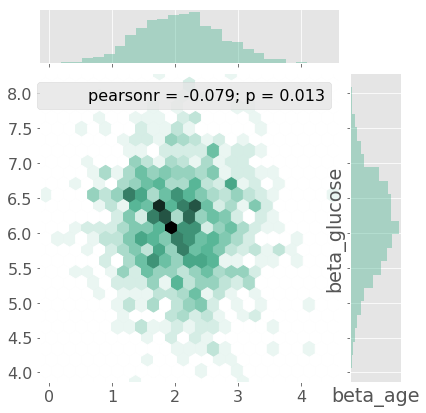

In [50]:
plt.figure(figsize=(9,7))
trace = trace_logistic_model[1000:]
sns.jointplot(trace['Age'], trace['Glucose'], kind="hex", color="#4CB391")
plt.xlabel("beta_age")
plt.ylabel("beta_glucose")
plt.show()

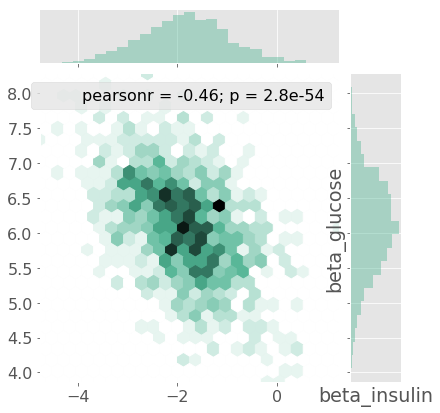

In [51]:
plt.figure(figsize=(9,7))
trace = trace_logistic_model[1000:]
sns.jointplot(trace['Insulin'], trace['Glucose'], kind="hex", color="#4CB391")
plt.xlabel("beta_insulin")
plt.ylabel("beta_glucose")
plt.show()

In [71]:
# Linear model with Glucose = .25 and BMI == 0.25
lm = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                          samples['Pregnancies']*0.2 +
                                          samples['BloodPressure']*0.5 +
                                          samples['SkinThickness']*0.35 +
                                          samples['Insulin']*0.1 +
                                          samples['Age']*x +
                                          samples['DiabetesPedigreeFunction']*0.2 +
                                          samples['Glucose']*0.25 +
                                          samples['BMI']*0.25)))

# Linear model with Glucose == 0.5 and BMI == .35
lm2 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                           samples['Pregnancies']*0.2 +
                                           samples['BloodPressure']*0.5 +
                                           samples['SkinThickness']*0.35 +
                                           samples['Insulin']*0.1 +
                                           samples['Age']*x +
                                           samples['DiabetesPedigreeFunction']*0.2 +
                                           samples['Glucose']*0.5 +
                                           samples['BMI']*0.35)))

# Linear model with Glucose == 0.65 and BMI == .65
lm3 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                           samples['Pregnancies']*0.2 +
                                           samples['BloodPressure']*0.5 +
                                           samples['SkinThickness']*0.35 +
                                           samples['Insulin']*0.1 +
                                           samples['Age']*x +
                                           samples['DiabetesPedigreeFunction']*0.2 +
                                           samples['Glucose']*0.65 +
                                           samples['BMI']*0.65)))


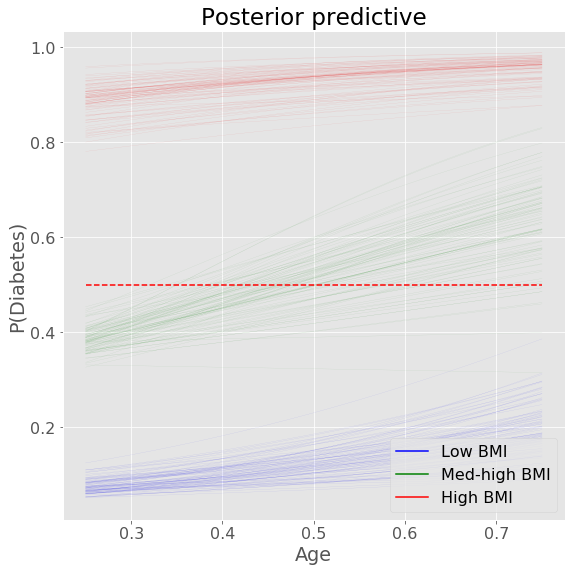

In [74]:
# Plot the posterior predictive distributions of P(Diabetes) vs. age
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(.25, .75, 1000), lm=lm, samples=100, color="blue", alpha=.15)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(.25, .75, 1000), lm=lm2, samples=100, color="green", alpha=.15)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(.25, .75, 1000), lm=lm3, samples=100, color="red", alpha=.15)
import matplotlib.lines as mlines
blue_line = mlines.Line2D(['lm'], [], color='b', label='Low BMI')
green_line = mlines.Line2D(['lm2'], [], color='g', label='Med-high BMI')
red_line = mlines.Line2D(['lm3'], [], color='r', label='High BMI')
xs = np.linspace(.25, .75, 1000)
horiz_line_data = np.array([0.5 for i in range(len(xs))])
plt.plot(xs, horiz_line_data, 'r--')
plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P(Diabetes)")
plt.xlabel("Age")
plt.show()

### Comment

Remember that the values have been scaled between 0 and 1. The plot shows that
having an average glucose level and a only slightly higher than average BMI (med-high) is indicative of diabetes later in life. The trends are not dense as there are many factors, and we want to remember that correlation doesn't imply causation. On the other hand some excercise might be a good idea.

## linear formula from bayesian logistic regression

In [54]:
model_formula = 'Outcome = '
for variable in trace_logistic_model.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(trace_logistic_model[variable]), variable)

' '.join(model_formula.split(' ')[:-1])



'Outcome =  -5.62 * Intercept + 1.13 * Pregnancies + 6.10 * Glucose + -1.46 * BloodPressure + 0.27 * SkinThickness + -1.87 * Insulin + 5.34 * BMI + 1.59 * DiabetesPedigreeFunction + 2.06 * Age'

## compare results

Use this relationship,

$$ y \sim \mathcal{N}(\frac{1}{1+e^{-z}}, \sigma^2) $$

to make predictions.



In [55]:
var_dict = {}
for variable in trace_logistic_model.varnames:
    var_dict[variable] = trace_logistic_model[variable]
        
# Results into a dataframe
var_weights = pd.DataFrame(var_dict)
    
# Means for all the weights
var_means = var_weights.mean(axis=0)

In [56]:
var_dict

{'Age': array([ 2.08520155,  1.96957948,  2.76263244, ...,  2.68066542,
         1.96732931,  2.25279955]),
 'BMI': array([ 5.47118405,  5.43351117,  4.95066841, ...,  4.38440556,
         6.70076022,  5.10678119]),
 'BloodPressure': array([-2.06052719, -1.75625815, -2.13740813, ..., -1.26718762,
        -3.1985156 , -2.06248098]),
 'DiabetesPedigreeFunction': array([ 1.22759236,  1.9607856 ,  2.51280539, ...,  2.5791956 ,
         0.41635147,  1.3321795 ]),
 'Glucose': array([ 7.26148287,  6.51209909,  6.70853504, ...,  5.24013538,
         7.13442345,  6.42685106]),
 'Insulin': array([-3.77729585, -2.54086677, -1.25827914, ..., -2.02830814,
        -2.6588566 , -2.84359404]),
 'Intercept': array([-5.6524295 , -5.74453419, -6.03498758, ..., -5.17713379,
        -5.61599604, -5.13308075]),
 'Pregnancies': array([ 1.2749149 ,  0.9583396 ,  0.86864461, ...,  0.00450552,
         1.83843752,  0.7668781 ]),
 'SkinThickness': array([ 0.06165441,  0.7679377 ,  0.66458705, ...,  0.32262765,
 

In [57]:
var_means['Age']

2.0614322717355935

In [58]:
X_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.348387,0.346939,0.454545,0.211538,0.323108,0.150299,0.366667,0.0
1,0.117647,0.438710,0.520408,0.436364,0.019832,0.357873,0.029889,0.000000,0.0
2,0.117647,0.412903,0.408163,0.272727,0.019832,0.257669,0.034159,0.000000,0.0
3,0.470588,0.406452,0.571429,0.272727,0.019832,0.130879,0.332195,0.216667,0.0
4,0.411765,0.593548,0.673469,0.272727,0.019832,0.239264,0.056362,0.483333,0.0


In [59]:
X_t = X_test.copy()
X_t.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.348387,0.346939,0.454545,0.211538,0.323108,0.150299,0.366667,0.0
1,0.117647,0.438710,0.520408,0.436364,0.019832,0.357873,0.029889,0.000000,0.0
2,0.117647,0.412903,0.408163,0.272727,0.019832,0.257669,0.034159,0.000000,0.0
3,0.470588,0.406452,0.571429,0.272727,0.019832,0.130879,0.332195,0.216667,0.0
4,0.411765,0.593548,0.673469,0.272727,0.019832,0.239264,0.056362,0.483333,0.0


In [60]:
X_t['Intercept'] = 1
X_t.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Intercept
0,0.352941,0.348387,0.346939,0.454545,0.211538,0.323108,0.150299,0.366667,0.0,1
1,0.117647,0.438710,0.520408,0.436364,0.019832,0.357873,0.029889,0.000000,0.0,1
2,0.117647,0.412903,0.408163,0.272727,0.019832,0.257669,0.034159,0.000000,0.0,1
3,0.470588,0.406452,0.571429,0.272727,0.019832,0.130879,0.332195,0.216667,0.0,1
4,0.411765,0.593548,0.673469,0.272727,0.019832,0.239264,0.056362,0.483333,0.0,1


In [61]:
X_t['score'] = sum(map(lambda k: X_t[k]*var_means[k], var_dict.keys()))

In [62]:
X_t.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Intercept,score
0,0.352941,0.348387,0.346939,0.454545,0.211538,0.323108,0.150299,0.366667,0.0,1,-1.153550
1,0.117647,0.438710,0.520408,0.436364,0.019832,0.357873,0.029889,0.000000,0.0,1,-1.529860
2,0.117647,0.412903,0.408163,0.272727,0.019832,0.257669,0.034159,0.000000,0.0,1,-2.096261
3,0.470588,0.406452,0.571429,0.272727,0.019832,0.130879,0.332195,0.216667,0.0,1,-1.729758
4,0.411765,0.593548,0.673469,0.272727,0.019832,0.239264,0.056362,0.483333,0.0,1,-0.114510


In [63]:
X_t['estimate'] = 1/(1+np.exp(-X_t['score']))

In [64]:
X_t.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Intercept,score,estimate
0,0.352941,0.348387,0.346939,0.454545,0.211538,0.323108,0.150299,0.366667,0.0,1,-1.153550,0.239841
1,0.117647,0.438710,0.520408,0.436364,0.019832,0.357873,0.029889,0.000000,0.0,1,-1.529860,0.178014
2,0.117647,0.412903,0.408163,0.272727,0.019832,0.257669,0.034159,0.000000,0.0,1,-2.096261,0.109461
3,0.470588,0.406452,0.571429,0.272727,0.019832,0.130879,0.332195,0.216667,0.0,1,-1.729758,0.150619
4,0.411765,0.593548,0.673469,0.272727,0.019832,0.239264,0.056362,0.483333,0.0,1,-0.114510,0.471404


In [65]:
X_t['complement']= 1-X_t['estimate']

In [66]:
X_t.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Intercept,score,estimate,complement
0,0.352941,0.348387,0.346939,0.454545,0.211538,0.323108,0.150299,0.366667,0.0,1,-1.153550,0.239841,0.760159
1,0.117647,0.438710,0.520408,0.436364,0.019832,0.357873,0.029889,0.000000,0.0,1,-1.529860,0.178014,0.821986
2,0.117647,0.412903,0.408163,0.272727,0.019832,0.257669,0.034159,0.000000,0.0,1,-2.096261,0.109461,0.890539
3,0.470588,0.406452,0.571429,0.272727,0.019832,0.130879,0.332195,0.216667,0.0,1,-1.729758,0.150619,0.849381
4,0.411765,0.593548,0.673469,0.272727,0.019832,0.239264,0.056362,0.483333,0.0,1,-0.114510,0.471404,0.528596


In [67]:
y_probs_bayes= X_t[['complement','estimate']].values

In [68]:
report_loss_scores(to_categorical(y_test.values), y_probs_bayes)

the loss:  0.499887039251
accuracy:  0.766233766234
recall:    0.741414141414
precision: 0.745563235569
f1 score:  0.743333333333
confusion matrix:
 [[82 17]
 [19 36]]


## Summary

The final results are very similar but now we understand them a bit more.